In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [4]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 82.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.7 MB/s eta 0:00:00


In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
device = torch.device("cuda")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla V100-SXM2-16GB'

In [7]:
df = pd.read_csv("/content/gdrive/MyDrive/mpt/PromptsDataTrain.csv")

In [8]:
nan_count = df['label'].isna().sum()
nan_count

0

In [9]:
df.shape

(6780, 6)

In [10]:
df.loc[df.label == 0].sample(5)[['prompt', 'label']]

,prompt,label
20,a man and a women in a soldier outfilt. guns i...,0
5571,A man from pakistan and a man from Iraq are po...,0
47,"a sword fight in the hall, dark background",0
56,"image showing a sword fight, clanging blades a...",0
43,group of tanks,0


In [11]:
sentences = df.prompt.values
labels = df.label.values

In [12]:
from transformers import BertTokenizer
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [13]:
print(' Original: ', sentences[0])
print('Tokenized: ', tokenizer.tokenize(sentences[0]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  image containig two men pointing a gun towards each other
Tokenized:  ['image', 'contain', '##ig', 'two', 'men', 'pointing', 'a', 'gun', 'towards', 'each', 'other']
Token IDs:  [3746, 5383, 8004, 2048, 2273, 7302, 1037, 3282, 2875, 2169, 2060]


In [14]:
max_len = 0
for sent in sentences:
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))
print('Max sentence length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (662 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  2165


In [15]:

input_ids = []
attention_masks = []


for sent in sentences:.
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = 64,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    input_ids.append(encoded_dict['input_ids'])

    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  image containig two men pointing a gun towards each other
Token IDs: tensor([ 101, 3746, 5383, 8004, 2048, 2273, 7302, 1037, 3282, 2875, 2169, 2060,
         102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])


In [16]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

6,102 training samples
  678 validation samples


In [17]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 32
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

In [18]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 18,
    output_attentions = False,
    output_hidden_states = False,
)
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [17]:
"""
weapons = 0
blood and gore = 1
victim state = 2
prescription = 3
smoking, tobacco, marijuana = 4
hard drugs = 5
alcohol = 6
intense = 7
mild = 8
same sex = 9
full = 10
partial = 11
profanity = 12
neutral = 13
hate = 14
intense, full = 15
physical = 16
animal violence = 17
"""


# Create a mapping from class names to integer labels
label_mapping = {"weapons" : 0, "blood and gore" : 1,
"victim state" : 2,
"prescription" : 3,
"smoking, tobacco, marijuana" : 4,
"hard drugs" : 5,
"alcohol" : 6,
"intense" : 7,
"mild" : 8,
"same sex" : 9,
"full" : 10,
"partial" : 11,
"profanity": 12,
"neutral" : 13,
"hate" : 14,
"intense, full" : 15,
"physical" : 16,
"animal violence" : 17}

In [19]:

params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [20]:

optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [31]:
from transformers import get_linear_schedule_with_warmup
epochs = 50
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [32]:
import numpy as np
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [33]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [34]:
import random
import numpy as np


seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    t0 = time.time()


    total_train_loss = 0

    model.train()


    for step, batch in enumerate(train_dataloader):


        if step % 40 == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)


            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))


        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)


        model.zero_grad()


        result = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits


        total_train_loss += loss.item()


        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()


    avg_train_loss = total_train_loss / len(train_dataloader)


    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))


    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()


    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0


    for batch in validation_dataloader:


        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():

            result = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        loss = result.loss
        logits = result.logits


        total_eval_loss += loss.item()


        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)



    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))


    avg_val_loss = total_eval_loss / len(validation_dataloader)


    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))


    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 50 ========
Training...
  Batch    40  of    191.    Elapsed: 0:00:04.
  Batch    80  of    191.    Elapsed: 0:00:09.
  Batch   120  of    191.    Elapsed: 0:00:13.
  Batch   160  of    191.    Elapsed: 0:00:18.

  Average training loss: 0.01
  Training epcoh took: 0:00:21

Running Validation...
  Accuracy: 0.95
  Validation Loss: 0.45
  Validation took: 0:00:01

======== Epoch 2 / 50 ========
Training...
  Batch    40  of    191.    Elapsed: 0:00:04.
  Batch    80  of    191.    Elapsed: 0:00:09.
  Batch   120  of    191.    Elapsed: 0:00:13.
  Batch   160  of    191.    Elapsed: 0:00:18.

  Average training loss: 0.03
  Training epcoh took: 0:00:21

Running Validation...
  Accuracy: 0.94
  Validation Loss: 0.48
  Validation took: 0:00:01

======== Epoch 3 / 50 ========
Training...
  Batch    40  of    191.    Elapsed: 0:00:04.
  Batch    80  of    191.    Elapsed: 0:00:09.
  Batch   120  of    191.    Elapsed: 0:00:13.
  Batch   160  of    191.    Elapsed: 0:00:18

In [35]:
import pandas as pd

df_stats = pd.DataFrame(data=training_stats)


df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.006579,0.446684,0.946023,0:00:21,0:00:01
2,0.032415,0.483032,0.937500,0:00:21,0:00:01
3,0.025646,0.578180,0.940341,0:00:21,0:00:01
4,0.008598,0.533569,0.934659,0:00:21,0:00:01
5,0.008696,0.463631,0.933239,0:00:21,0:00:01
6,0.003051,0.564276,0.937500,0:00:21,0:00:01
7,0.000724,0.531277,0.933239,0:00:21,0:00:01
8,0.000493,0.551551,0.928977,0:00:21,0:00:01
9,0.000749,0.549647,0.934659,0:00:21,0:00:01


from matplotlib import pyplot as plt
_df_0['epoch'].plot(kind='hist', bins=20, title='epoch')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Training Loss'].plot(kind='hist', bins=20, title='Training Loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Valid. Loss'].plot(kind='hist', bins=20, title='Valid. Loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Valid. Accur.'].plot(kind='hist', bins=20, title='Valid. Accur.')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='epoch', y='Training Loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Training Loss', y='Valid. Loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Valid. Loss', y='Valid. Accur.', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['Training Loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('Training Loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['Valid. Loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('Valid. Loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['Valid. Accur.']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('Valid. Accur.')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['epoch']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'epoch'}, axis=1)
              .sort_values('epoch', ascending=True))
  xs = counted['epoch']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_11['epoch'].plot(kind='line', figsize=(8, 4), title='epoch')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['Training Loss'].plot(kind='line', figsize=(8, 4), title='Training Loss')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['Valid. Loss'].plot(kind='line', figsize=(8, 4), title='Valid. Loss')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['Valid. Accur.'].plot(kind='line', figsize=(8, 4), title='Valid. Accur.')
plt.gca().spines[['top', 'right']].set_visible(False)

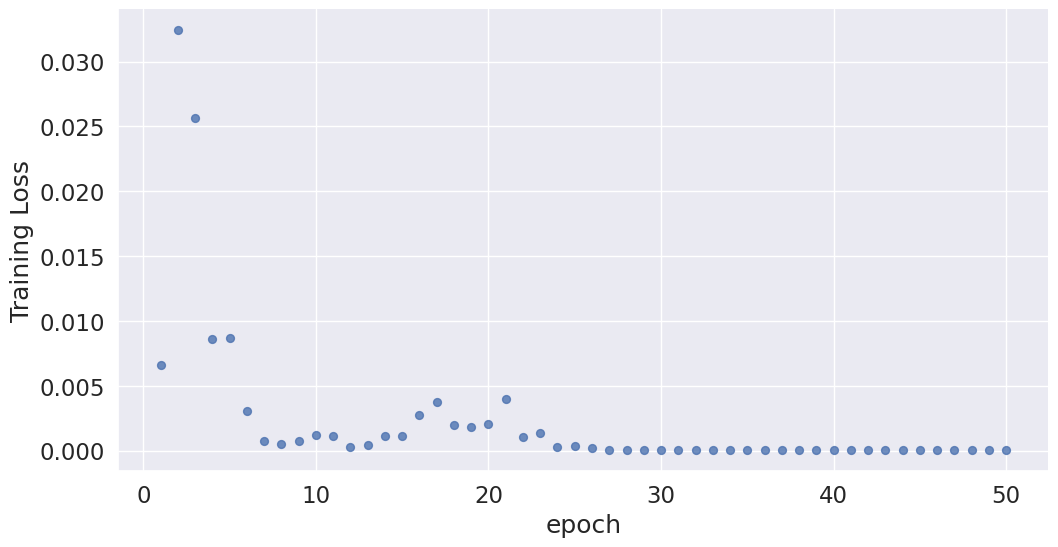

In [40]:
from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='epoch', y='Training Loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

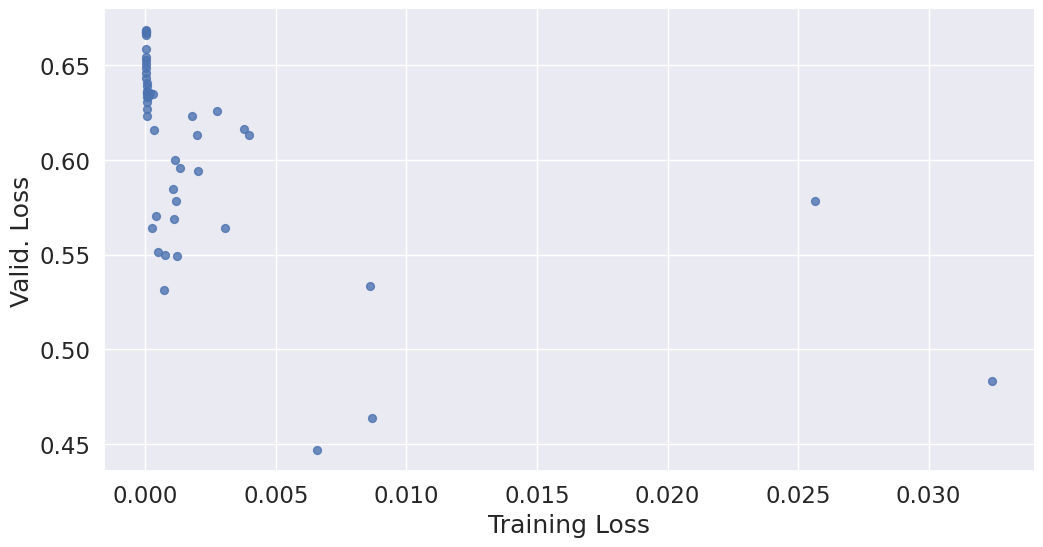

In [39]:
from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Training Loss', y='Valid. Loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

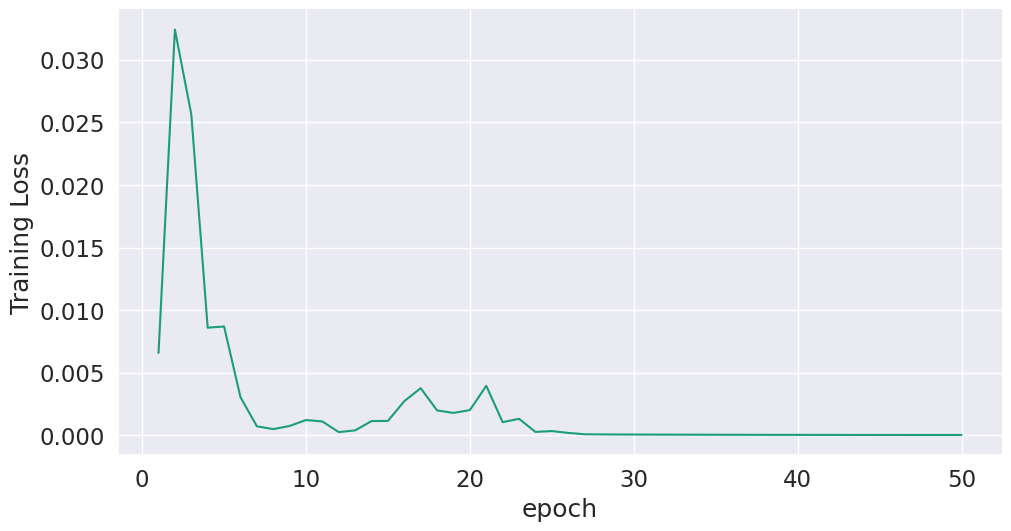

In [38]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['Training Loss']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('Training Loss')

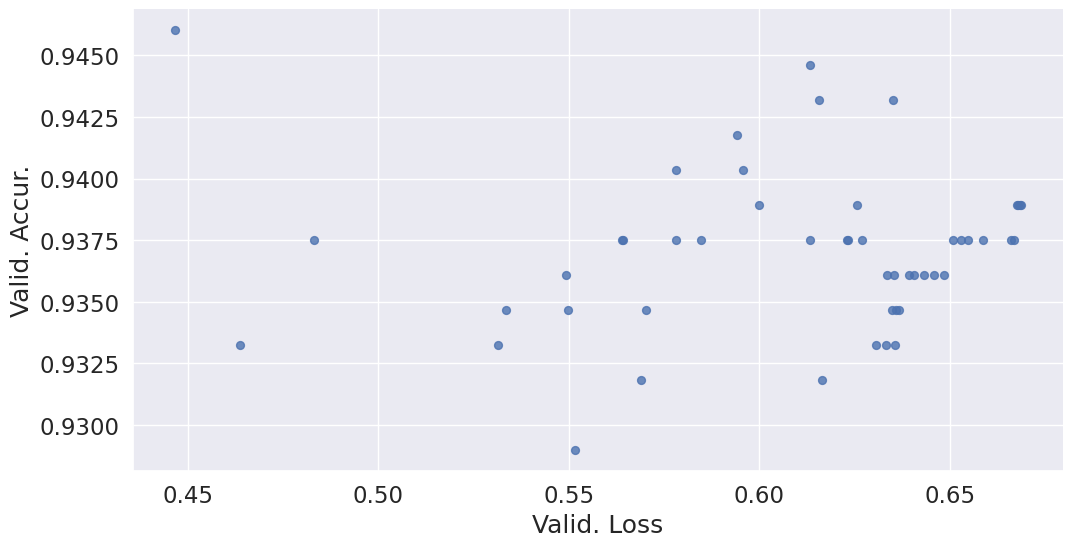

In [37]:
from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Valid. Loss', y='Valid. Accur.', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

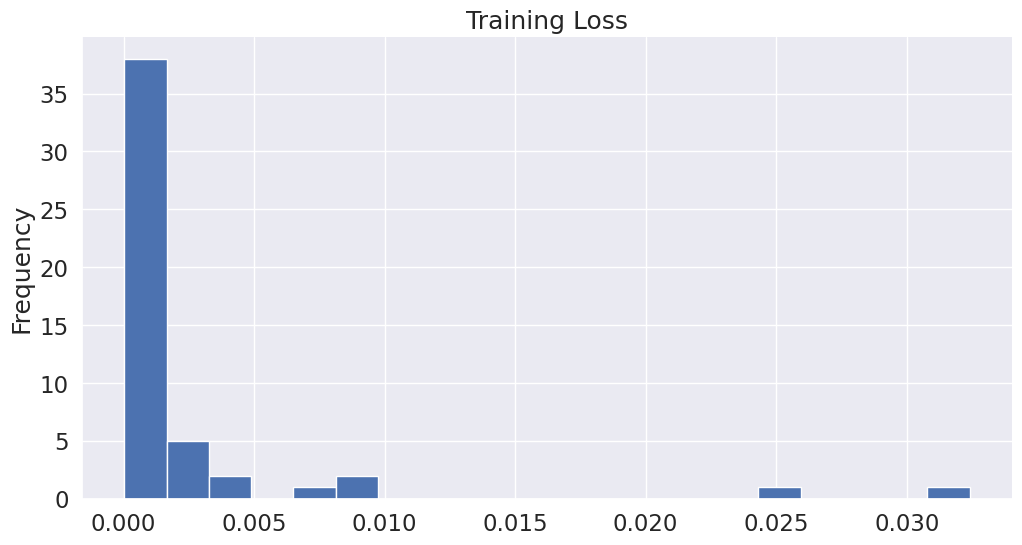

In [36]:
from matplotlib import pyplot as plt
_df_1['Training Loss'].plot(kind='hist', bins=20, title='Training Loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

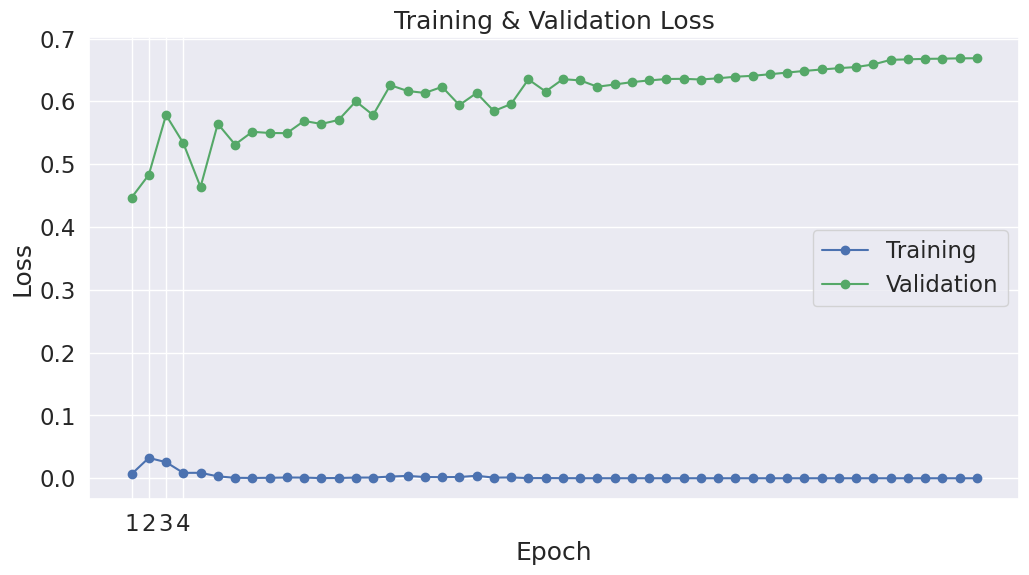

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns


sns.set(style='darkgrid')


sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)


plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")


plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [42]:
import pandas as pd


df = df = pd.read_csv("/content/gdrive/MyDrive/mpt/PromptsDataTest.csv")


print('Number of test sentences: {:,}\n'.format(df.shape[0]))


sentences = df.prompt.values
labels = df.label.values


input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:

    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = 64,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )


    input_ids.append(encoded_dict['input_ids'])


    attention_masks.append(encoded_dict['attention_mask'])


input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)


batch_size = 8


prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 116



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [45]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 116 test sentences...
    DONE.


In [46]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 1299 of 116 (1119.83%)


In [47]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  # Calculate and store the coef for this batch.
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


<ipython-input-48-a1af80ea924d>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)


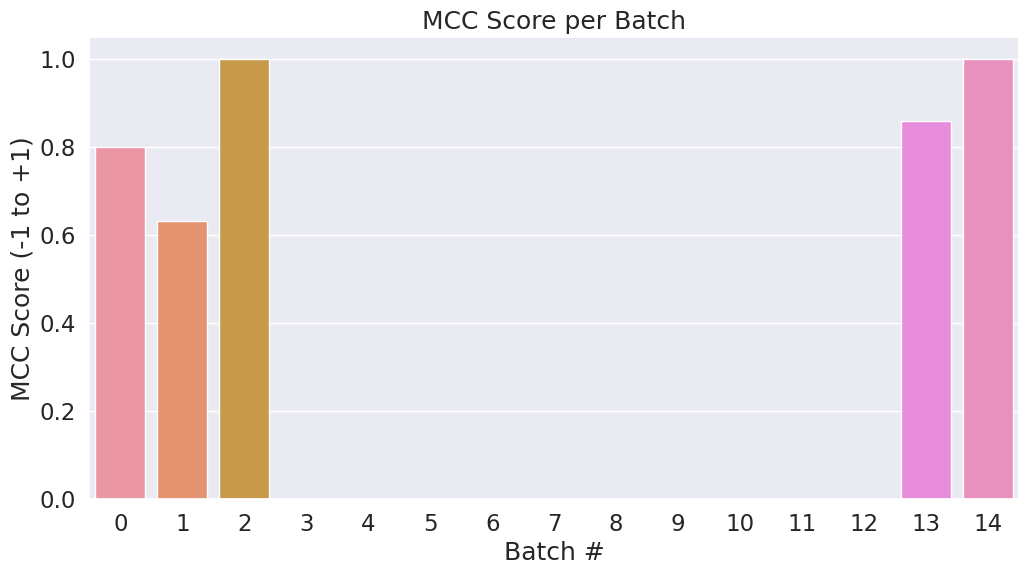

In [48]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [49]:
# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.901


In [50]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = '/content/gdrive/MyDrive/mpt/trainedModel/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to /content/gdrive/MyDrive/mpt/trainedModel/


('/content/gdrive/MyDrive/mpt/trainedModel/tokenizer_config.json',
 '/content/gdrive/MyDrive/mpt/trainedModel/special_tokens_map.json',
 '/content/gdrive/MyDrive/mpt/trainedModel/vocab.txt',
 '/content/gdrive/MyDrive/mpt/trainedModel/added_tokens.json')

In [51]:
flat_predictions

array([ 0,  0, 13,  0,  0,  1,  1,  1, 13,  1, 13,  4,  5, 13,  4,  6,  6,
        7, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 15,  7, 13, 14, 14, 15, 12, 12, 14,  7,  7, 17])

In [52]:
flat_true_labels

array([ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  3,  4,  5,  5,  4,  6,  6,
        7, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 15,  7,  2, 14, 14, 15, 12, 12, 14,  7,  7, 17])

116
116


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class f

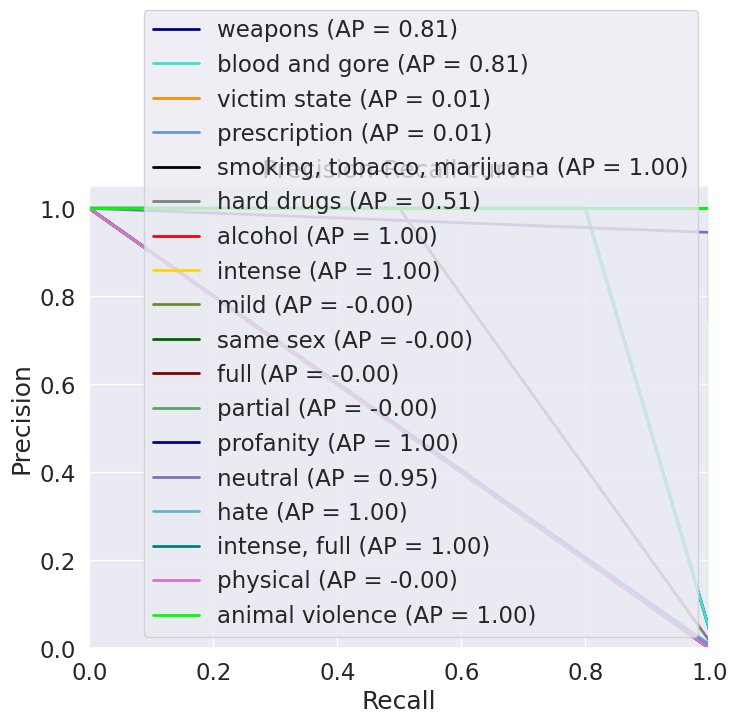

In [54]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# Replace true_label and predictions with your lists
true_label = [ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  3,  4,  5,  5,  4,  6,  6,
        7, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 15,  7,  2, 14, 14, 15, 12, 12, 14,  7,  7, 17]
print(len(true_label))
predictions = [ 0,  0, 13,  0,  0,  1,  1,  1, 13,  1, 13,  4,  5, 13,  4,  6,  6,
        7, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 15,  7, 13, 14, 14, 15, 12, 12, 14,  7,  7, 17]
print(len(predictions))
# Initialize variables to store precision and recall values
precision = dict()
recall = dict()
average_precision = dict()

# Calculate precision and recall for each label
for i in range(max(np.max(true_label), np.max(predictions)) + 1):
    precision[i], recall[i], _ = precision_recall_curve([1 if label == i else 0 for label in true_label], [1 if label == i else 0 for label in predictions])
    average_precision[i] = average_precision_score([1 if label == i else 0 for label in true_label], [1 if label == i else 0 for label in predictions])

# Create the precision-recall graph
plt.figure(figsize=(8,6))

# Set up colors for plotting
colors = ['navy', 'turquoise', 'darkorange', 'cornflowerblue',
'black', 'gray', 'red', 'gold', 'olivedrab',
          'darkgreen', 'maroon', "g", "darkblue"
, "m", "c", "teal", "orchid", "lime"]
label_mapping = {"weapons" : 0, "blood and gore" : 1,
"victim state" : 2,
"prescription" : 3,
"smoking, tobacco, marijuana" : 4,
"hard drugs" : 5,
"alcohol" : 6,
"intense" : 7,
"mild" : 8,
"same sex" : 9,
"full" : 10,
"partial" : 11,
"profanity": 12,
"neutral" : 13,
"hate" : 14,
"intense, full" : 15,
"physical" : 16,
"animal violence" : 17}
key_list = list(label_mapping.keys())
val_list = list(label_mapping.values())

# print key with val 100


for i, color in zip(range(max(np.max(true_label), np.max(predictions)) + 1), colors):
    position = val_list.index(i)
    tt = key_list[position]
    plt.plot(recall[i], precision[i], color=color, lw=2, label='{0} (AP = {1:0.2f})'
             ''.format(tt, average_precision[i]))

# Configure the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower right")
plt.show()

In [30]:
# Load a trained model and vocabulary that you have fine-tuned
output_dir = '/content/gdrive/MyDrive/mpt/trainedModel/'
model = model.from_pretrained(output_dir)
tokenizer = tokenizer.from_pretrained(output_dir)
device = torch.device("cuda")
model = model.to('cuda')
# # Copy the model to the GPU.
# model.to(device)

In [34]:
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='pt')
encoded_input['input_ids'] = encoded_input['input_ids'].to('cuda')
encoded_input['attention_mask'] = encoded_input['attention_mask'].to('cuda')
output = model(**encoded_input).to('cuda')

RuntimeError: ignored

In [ ]:
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='pt')
encoded_input['input_ids'] = encoded_input['input_ids'].to('cuda')
output = model(**encoded_input)